### NN Vector Pull for Direction

Mar 07 20232024
TJ Kim

##### Summary
Load any NN model. Obtain layer by layer the unit direction vector (against vector of zeros). See if cosine similarity can be used as a metric to measure direction.

Performing for celeba

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *
torch.cuda.empty_cache()


In [3]:
setting, num_user, experiment  = "FedAvg_adv", 40, 'celeba'

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user, experiment)

# Load models for FAT and FedAvg
# save_path_FAT = 'weights/celeba/240229_LateFAT/FAT/'
# save_path_FedAvg = 'weights/celeba/240222_FedAvg200round_lr001/fedavg/'
save_path_FAT = 'weights/celeba/240311_small_architecture_moreconv/FAT/'
save_path_FedAvg = 'weights/celeba/240311_small_architecture_moreconv/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 26%|██▌       | 39/150 [00:00<00:01, 87.22it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [5]:
# Find mag norm 
mag_norm_FedAvg2FAT = []
for key in desired_keys: #params_FAT:

    diff = params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FedAvg2FAT += [diff/torch.norm(diff,p=2)]


In [19]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 20
peturb_prop = 0.5

setting = 'FedAvg_adv'

test_acc_gather = []
adv_acc_gather = []
cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

save_path_FAT150 = save_path_FAT

# aggregator, clients, args_ = set_args(setting, num_user)

for client in aggregator.clients:
    client.dataset_name = experiment

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FAT150)
aggregator.update_clients()
model_FAT = pull_model_from_agg(aggregator)
model_FAT.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FAT)

prev_model = copy.deepcopy(model_FAT)

print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]

# Setting evasion attack parameters
x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
atk_params = PGD_Params()
atk_params.set_params(batch_size=1, iteration = 10,
                target = -1, x_val_min = x_min, x_val_max = x_max,
                step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

for c in aggregator.clients:
    c.unlearning_flag = True

for i in range(num_rounds):
    if i%5 == 0:
        # Assign proportion and attack params
        if i < 10:
            for c in range(len(clients)):
                aggregator.clients[c].set_adv_params(peturb_prop, atk_params)
                aggregator.clients[c].update_advnn()
                aggregator.clients[c].assign_advdataset()
        else:
             for c in range(len(clients)):
                aggregator.clients[c].reset_dataset()

    aggregator.mix()
    model_overfit = pull_model_from_agg(aggregator)
    model_overfit.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)

    diffnn = get_diff_NN(prev_model, model_overfit, desired_keys)

    cosine_gather_layers[i,:] = diff_cosine_similarity(diffnn, mag_norm_FedAvg2FAT, len(desired_keys))
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    prev_model = copy.deepcopy(model_overfit)
    # Perform gradient direction gathering




Test acc:  0.6879137448966504 adv acc:  0.526066686026752
round 0 Test acc:  0.6149725675582886 adv acc:  0.4522068750113249
round 1 Test acc:  0.6280911941081285 adv acc:  0.45017844904214144
round 2 Test acc:  0.6027284468524158 adv acc:  0.4236294268630445
round 3 Test acc:  0.6640235468745231 adv acc:  0.4719431521371007
round 4 Test acc:  0.6366921775974334 adv acc:  0.4361304083839059
round 5 Test acc:  0.6505000177770853 adv acc:  0.4534617805853486
round 6 Test acc:  0.6431382551789284 adv acc:  0.46518727075308564
round 7 Test acc:  0.6390862949192524 adv acc:  0.44258726965636014
round 8 Test acc:  0.6479657053947449 adv acc:  0.4665353115648031
round 9 Test acc:  0.6573853146284818 adv acc:  0.46141472049057486
round 10 Test acc:  0.6539706090465188 adv acc:  0.4739147225394845
round 11 Test acc:  0.6669480630196631 adv acc:  0.46551472032442687
round 12 Test acc:  0.6482108014635741 adv acc:  0.4547823646105826
round 13 Test acc:  0.640863747522235 adv acc:  0.4553166802972

In [20]:
i

19

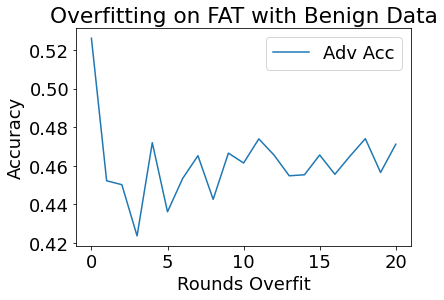

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


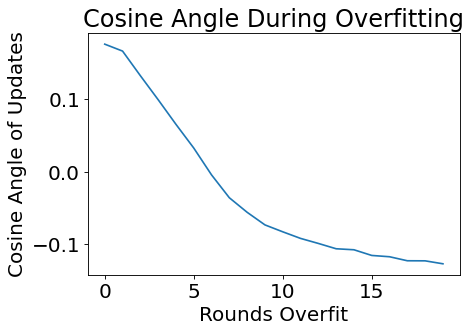

In [22]:
np.mean(cosine_gather_layers,axis = 1)

import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
y1 = np.mean(cosine_gather_layers,axis = 1)
x = range(len(y1))  # 100 points from 0 to 10


# Plotting the lines
plt.plot(x, y1)

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Cosine Angle of Updates')
plt.title('Cosine Angle During Overfitting')

# Adding a legend
# plt.legend()

# Display the plot
plt.show()


In [24]:
# print(x)
print(y1)
# print(y2)


[0.18 0.17 0.13 0.10 0.07 0.03 -0.00 -0.04 -0.06 -0.07 -0.08 -0.09 -0.10
 -0.11 -0.11 -0.12 -0.12 -0.12 -0.12 -0.13]


Trial 1

[0.11 0.12 0.12 0.10 0.09 0.08 0.07 0.07 0.06 0.06 0.07 0.06 0.07 0.05
 0.06 0.05 0.06 0.06 0.07 0.06]
[0.3100000023841858, 0.27400001883506775, 0.3060000240802765, 0.25600001215934753, 0.25, 0.20400001108646393, 0.21000000834465027, 0.23000000417232513, 0.22600001096725464, 0.19200000166893005, 0.23600001633167267, 0.20000000298023224, 0.23600001633167267, 0.2800000011920929, 0.25, 0.20200000703334808, 0.21000000834465027, 0.23400001227855682, 0.2600000202655792, 0.23000000417232513, 0.1860000044107437]

In [10]:
# Get number of params per desired key
size = np.zeros(len(desired_keys))
i = 0
for key in desired_keys:
    size[i]=params_FAT[key].flatten().shape[0]
    i += 1

prop = size/np.sum(size)

cosine_propped = np.zeros(cosine_gather_layers.shape)

# for t in range(num_rounds):
#     cosine_propped[t,:] = np.average(cosine_gather_layers[t,:], weights = prop)

np.average(cosine_gather_layers, weights = prop, axis = 1)

array([0.03, 0.03, 0.01, 0.00, 0.00, 0.01, -0.02, -0.03, -0.04, -0.04,
       -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04,
       -0.05])

Text(0.5, 1.0, 'Per Layer Cosine Angle Round 1')

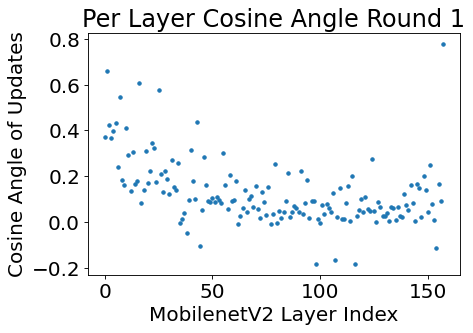

In [11]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plt.plot(cosine_gather_layers[0],'.')

# Adding labels and title
plt.xlabel('MobilenetV2 Layer Index')
plt.ylabel('Cosine Angle of Updates')
plt.title('Per Layer Cosine Angle Round 1')